In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
%matplotlib inline


import numpy as np
import autoreject
import csv
import matplotlib.pyplot as plt
import pandas as pd
import mne
import os
import sys
from atpbar import atpbar
import glob
from mne.stats import permutation_cluster_test
from scipy.stats import ttest_rel



In [2]:
# Suppress MNE output
#mne.set_log_level('WARNING')
mne.set_log_level('ERROR')
#mne.set_log_level('CRITICAL')
#mne.set_log_level('INFO')



## Visualisation to test for outliers

In [3]:
# # loop to check each individual response and see which ones I wish to exclude

# for sub in range(10):
#     for day in [1,2,3,4]:
#         for meditation in ['jhana', 'mindfulness']:
        
#             print(f'sub{sub} {day} {meditation}')
#             path = f'/Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/MMN/epochs_ar/sub{sub}-day{day}-{meditation}_epo.fif'
#             try:
#                 epochs = mne.read_epochs(path)
#                 epochs.interpolate_bads(reset_bads=True).pick_types(eeg=True).filter(l_freq=None, h_freq=40)
#                 epochs.pick_channels(['Fz', 'Cz', 'FC1', 'FC2'])

#                 # # Plotting the evoked response
#                 # evokeds = epochs.average()
#                 # evokeds.plot()

#                 # Plotting the MMN
#                 evokeds_dev = epochs['-1'].average()
#                 evokeds_std = epochs['1'].average()

#                 evo_m_diff = mne.combine_evoked([evokeds_dev, evokeds_std], weights=[1, -1])
#                 evo_m_diff.plot(window_title="Mindfulness Difference", gfp=True, time_unit="s")
#             except: 
#                 pass

## Import evoked responses into big dictionary

In [4]:
# Importing the data
evokeds = {}
for meditation in ['jhana', 'mindfulness']:
    evokeds[meditation] = {}
    evokeds[meditation]['std'] = []
    evokeds[meditation]['dev'] = []
    evokeds[meditation]['mmn'] = []


#for sub in [0,1,2,4,7,8,9]:
for sub in range(10):
    for meditation in ['jhana', 'mindfulness']:
        paths = glob.glob(f'/Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/MMN/epochs_ar/sub{sub}-day*-{meditation}_epo.fif')
        epochs_list = [mne.read_epochs(path) for path in paths]
        epochs_list_picks = []
        
        for i in range(len(epochs_list)):
            epochs_list[i] = epochs_list[i].interpolate_bads(reset_bads=True).pick_types(eeg=True).filter(l_freq=None, h_freq=40)
                
        concatenated_epochs = mne.concatenate_epochs(epochs_list)
        evokeds[meditation]['std'].append(concatenated_epochs['1'].average())
        evokeds[meditation]['dev'].append(concatenated_epochs['-1'].average())
        evokeds[meditation]['mmn'].append(mne.combine_evoked([evokeds[meditation]['dev'][-1], evokeds[meditation]['std'][-1]], weights=[1, -1]))
        

## Creating MMN

In [5]:
# Creating the evoked responses

evo_j_std = mne.combine_evoked(evokeds['jhana']['std'], weights='equal')
evo_j_dev = mne.combine_evoked(evokeds['jhana']['dev'], weights='equal')
evo_m_std = mne.combine_evoked(evokeds['mindfulness']['std'], weights='equal')
evo_m_dev = mne.combine_evoked(evokeds['mindfulness']['dev'], weights='equal')

evo_all_std = mne.combine_evoked([evo_j_std, evo_m_std], weights='equal')
evo_all_dev = mne.combine_evoked([evo_j_dev, evo_m_dev], weights='equal')
evo_all_all = mne.combine_evoked([evo_all_std, evo_all_dev], weights='nave')


## Visualizing MMNs and topo

overall global response


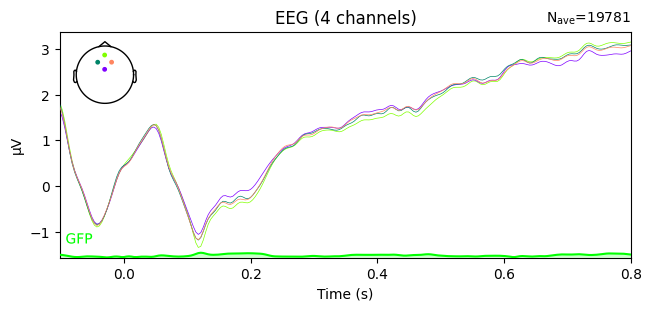

Global Evoked Response


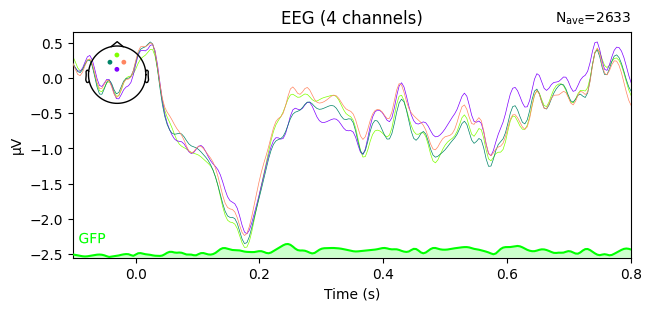

Jhana Evoked Response


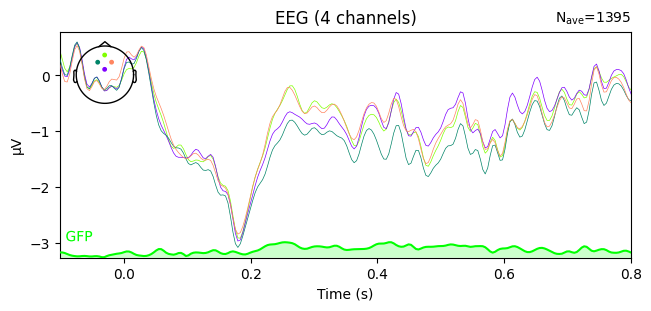

Mindfulnesss Evoked Response


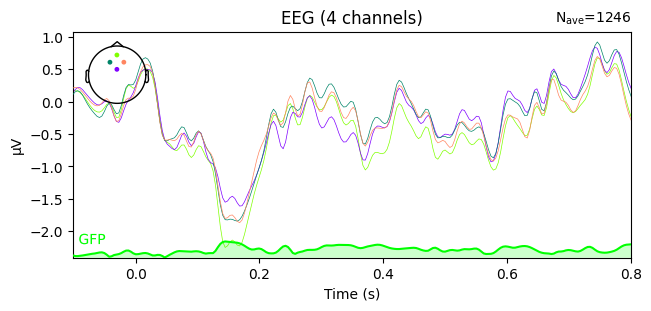

In [32]:
# Plotting the evoked responses for different conditions
print ('overall global response')
evo_all_all.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="overall global response", gfp=True, time_unit="s")

print('Global Evoked Response')
evo_diff = mne.combine_evoked([evo_all_dev, evo_all_std], weights=[1, -1])
evo_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Global Evoked Response", gfp=True, time_unit="s")

print('Jhana Evoked Response')
evo_j_diff = mne.combine_evoked([evo_j_dev, evo_j_std], weights=[1, -1])
evo_j_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Jhana Difference", gfp=True, time_unit="s")

print('Mindfulnesss Evoked Response')
evo_m_diff = mne.combine_evoked([evo_m_dev, evo_m_std], weights=[1, -1])
evo_m_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Mindfulness Difference", gfp=True, time_unit="s")

evo_jm_diff = mne.combine_evoked([evo_j_diff, evo_m_diff], weights=[1, -1])


# for sub in range(10):
#     print (30*"#")
#     print (f'MMN, Jhana, sub: {sub}')
#     evo_j_diff_sub = mne.combine_evoked([evokeds['jhana']['dev'][sub], evokeds['jhana']['std'][sub]], weights=[1, -1])
#     evo_j_diff_sub.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Mindfulness Difference", gfp=True, time_unit="s")

#     print (f'MMN, Mindfulness, sub: {sub}')
#     evo_m_diff_sub = mne.combine_evoked([evokeds['mindfulness']['dev'][sub], evokeds['mindfulness']['std'][sub]], weights=[1, -1])
#     evo_m_diff_sub.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Mindfulness Difference", gfp=True, time_unit="s")

print('')

## Visualise the grant average across all channels and for both conditions in one plot

In [248]:
data_j = evo_j_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).get_data()
data_m = evo_m_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).get_data()

mean_j = data_j.mean(axis=0)
mean_m = data_m.mean(axis=0)
mean_dif = mean_j-mean_m

evo_j_std_ave = evo_j_std.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).get_data().mean(axis=0)
evo_j_dev_ave = evo_j_dev.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).get_data().mean(axis=0)
evo_m_std_ave = evo_m_std.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).get_data().mean(axis=0)
evo_m_dev_ave = evo_m_dev.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).get_data().mean(axis=0)



## Repeated measure ANOVA

In [297]:
import numpy as np
import pandas as pd
from statsmodels.stats.anova import AnovaRM
import mne

# Initialize storage for MMN data
mmn_data = {'Subject': [], 'Condition': [], 'Time': [], 'Amplitude': []}

# Process data for both conditions and all subjects
for meditation in ['jhana', 'mindfulness']:
    for sub in range(10):
        # Combine deviant and standard conditions
        mmn_ind = mne.combine_evoked(
            [evokeds[meditation]['dev'][sub], evokeds[meditation]['std'][sub]], weights='equal'
        )
        # Select relevant channels
        mmn_ind.pick_channels(['Fz', 'Cz', 'FC1', 'FC2'])
        # Get data and average over channels
        mmn_ind_data = mmn_ind.get_data().mean(axis=0)
        
        # Store the data for this subject and condition
        for t_idx, amplitude in enumerate(mmn_ind_data):
            mmn_data['Subject'].append(sub)
            mmn_data['Condition'].append(meditation)
            mmn_data['Time'].append(mmn_ind.times[t_idx])
            mmn_data['Amplitude'].append(amplitude)

# Convert to DataFrame
df_mmn = pd.DataFrame(mmn_data)

# Filter for specific time window (e.g., 100–200 ms)
time_window = (df_mmn['Time'] >= 0.15) & (df_mmn['Time'] <= 0.2)
df_window = df_mmn[time_window]

# Average amplitude within the time window for each subject and condition
df_avg = df_window.groupby(['Subject', 'Condition'])['Amplitude'].mean().reset_index()

# Reshape data for repeated-measures ANOVA
df_pivot = df_avg.pivot(index='Subject', columns='Condition', values='Amplitude').reset_index()

# Perform repeated-measures ANOVA
anova_df = pd.melt(df_pivot, id_vars='Subject', value_vars=['jhana', 'mindfulness'], var_name='Condition', value_name='MMN')
anova = AnovaRM(anova_df, 'MMN', 'Subject', within=['Condition']).fit()
print(anova.summary())


                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
Condition  0.0749 1.0000 9.0000 0.7906



## Helper functions for cluster permutation test

In [7]:
# Create evokeds_array object

evokeds_array = np.zeros([10,2,3,232])
for sub in range(10):
    for meditation_n, meditation in enumerate(['jhana', 'mindfulness']):
        for condition_n, condition in enumerate(['std','dev','mmn']):
            evokeds_array[sub,meditation_n,condition_n,:] = evokeds[meditation][condition][sub].copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).get_data().mean(axis=0)

mean_j = evokeds_array[:,0,2,:].mean(axis=0)
mean_m = evokeds_array[:,1,2,:].mean(axis=0)
mean_dif = mean_j - mean_m

In [8]:
# function to cut the evokeds array

def cut_array(evokeds_array, start,end):
    start_samp = int(np.round((start+0.1)*256))
    end_samp = int(np.round((end+0.1)*256))
    evokeds_array_t = evokeds_array[:,:,:,start_samp:end_samp]   
    return (evokeds_array_t)


In [12]:
# function to plot the cluster permutation results
time = np.linspace(-0.1, 0.8, 232)  # From -0.1s to 0.8s

def plot_cluster_permutation (time_series, time, title, clusters, start, end):
    
    plt.figure(figsize=(10, 6))
    for i in range(len(time_series)):
        plt.plot(time, time_series[i][0], label=time_series[i][1], linewidth=1, linestyle=time_series[i][2])
    

    for cluster in clusters:
        plt.axvspan(float(cluster[0][0]+start*256)/256, float(cluster[0][-1]+start*256)/256, color='yellow', alpha=0.3, label='cluster')
    
    plt.axvline(x=start, color='red', linestyle='--', linewidth=1)  # Example: vertical line at x=0
    plt.axvline(x=end, color='red', linestyle='--', linewidth=1)  # Example: vertical line at x=0

    
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Amplitude (µV)', fontsize=14)  # µV is the common unit for EEG
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Cluster Permutation Tests

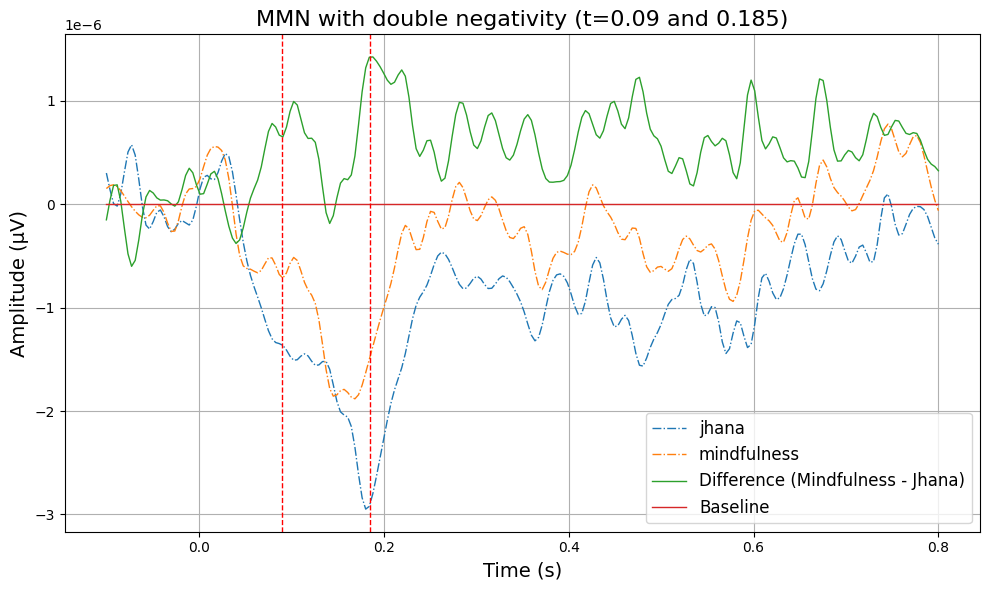

standard
[]
[]


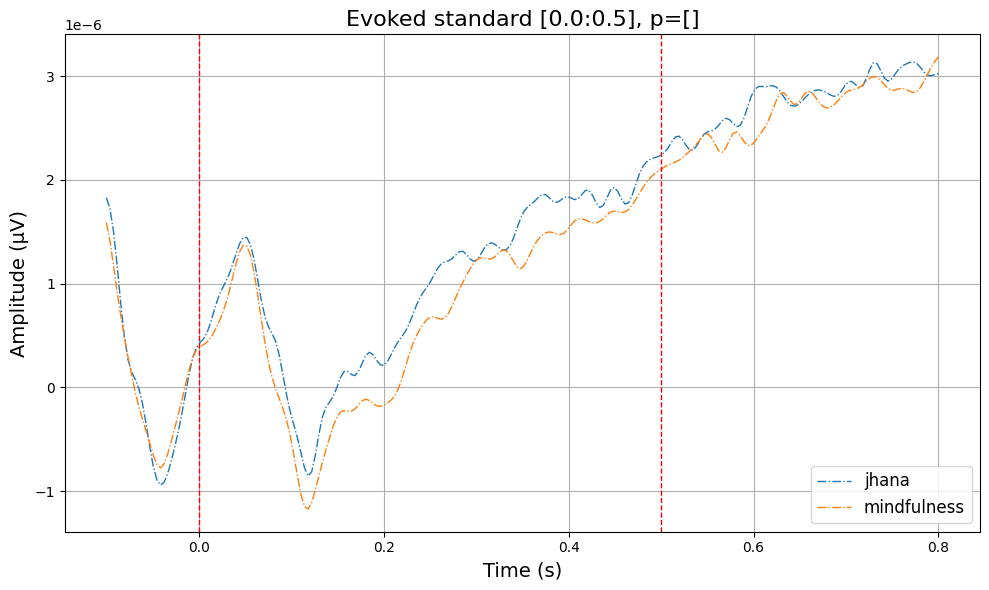

deviant
[]
[]


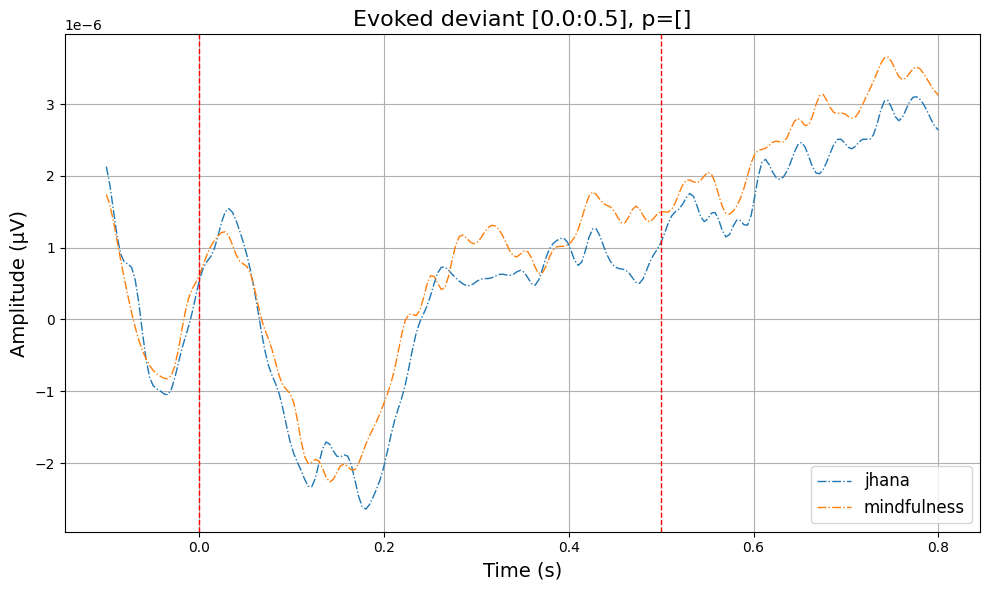

mmn
[(array([25, 26]),), (array([46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]),), (array([113, 114, 115, 116, 117]),), (array([120, 121, 122, 123]),)]
[0.81994629 0.17785645 0.56030273 0.66784668]


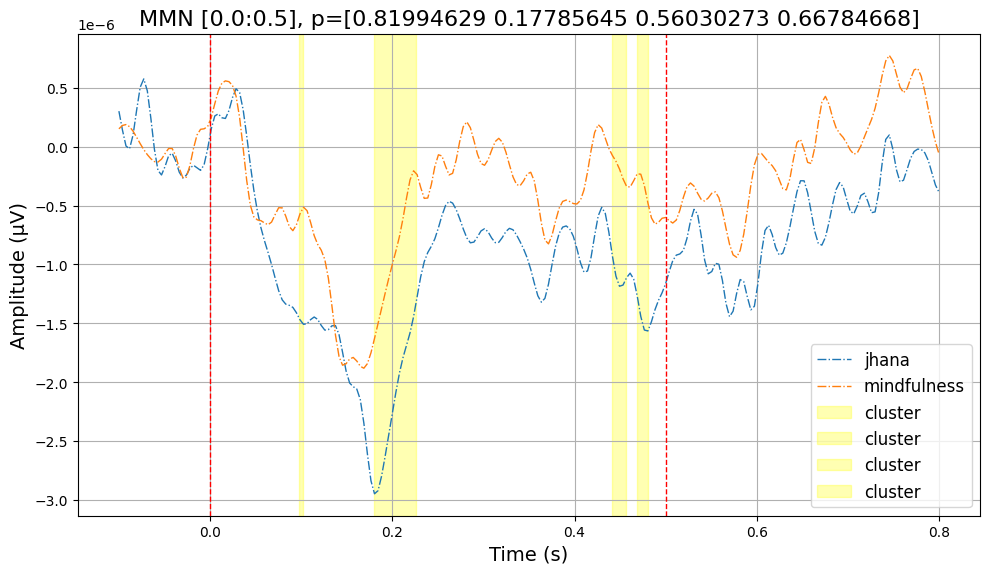

mmn
[(array([0, 1]),), (array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),)]
[0.47583008 0.07556152]


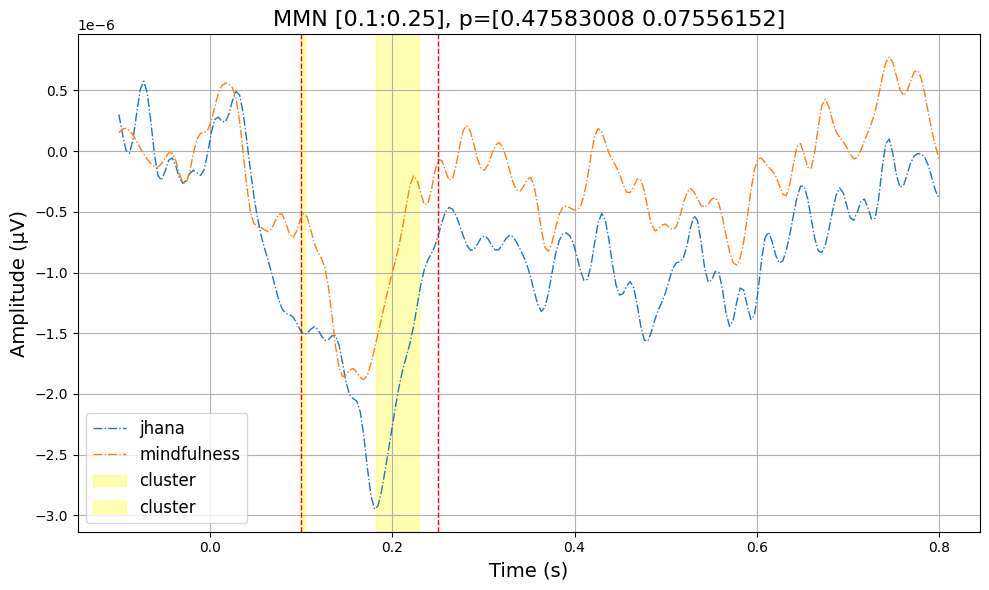

mmn
[(array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),)]
[0.0513916]


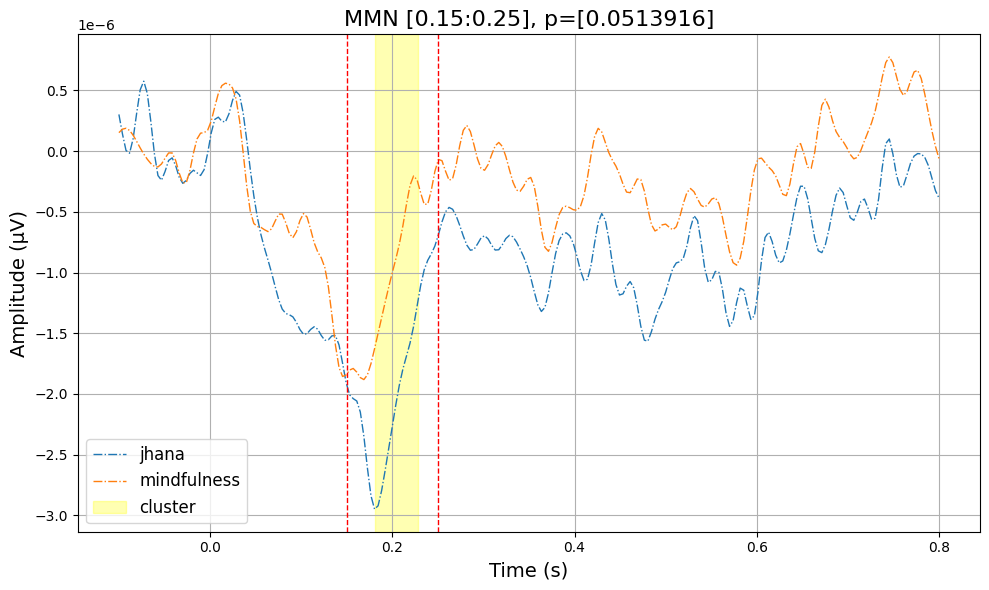

In [35]:
start = 0.0
end = 0.5

evokeds_array_t = cut_array(evokeds_array, start, end)

time_series = [
    [evokeds_array[:,0,2,:].mean(axis=0), 'jhana', 'dashdot'],
    [evokeds_array[:,1,2,:].mean(axis=0), 'mindfulness', 'dashdot'],
    [evokeds_array[:,1,2,:].mean(axis=0)-evokeds_array[:,0,2,:].mean(axis=0), 'Difference (Mindfulness - Jhana)', '-'],
    [np.zeros(232), 'Baseline', '-']
]
plot_cluster_permutation (time_series, time, title='MMN with double negativity (t=0.09 and 0.185)', clusters=[], start=0.09, end=0.185)


print('standard')
X =[evokeds_array_t[:,0,0,:], evokeds_array_t[:,1,0,:]]
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=2.6, n_permutations=8192)
print(clusters)
print(cluster_p_values)
time_series = [
    [evokeds_array[:,0,0,:].mean(axis=0), 'jhana', 'dashdot'],
    [evokeds_array[:,1,0,:].mean(axis=0), 'mindfulness', 'dashdot'],
]
plot_cluster_permutation (time_series, time, title=f'Evoked standard [{start}:{end}], p={cluster_p_values}', clusters=clusters, start=start, end=end)

print('deviant')
X =[evokeds_array_t[:,0,1,:], evokeds_array_t[:,1,1,:]]
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=2.6, n_permutations=8192)
print(clusters)
print(cluster_p_values)
time_series = [
    [evokeds_array[:,0,1,:].mean(axis=0), 'jhana', 'dashdot'],
    [evokeds_array[:,1,1,:].mean(axis=0), 'mindfulness', 'dashdot'],
]
plot_cluster_permutation (time_series, time, title=f'Evoked deviant [{start}:{end}], p={cluster_p_values}', clusters=clusters, start=start, end=end)

print('mmn')
X =[evokeds_array_t[:,0,2,:], evokeds_array_t[:,1,2,:]]
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=2.6, n_permutations=8192)
print(clusters)
print(cluster_p_values)
time_series = [
    [evokeds_array[:,0,2,:].mean(axis=0), 'jhana', 'dashdot'],
    [evokeds_array[:,1,2,:].mean(axis=0), 'mindfulness', 'dashdot'],
]
plot_cluster_permutation (time_series, time, title=f'MMN [{start}:{end}], p={cluster_p_values}', clusters=clusters, start=start, end=end)


print('mmn')
start = 0.1
end = 0.25
evokeds_array_t = cut_array(evokeds_array, start, end)

X =[evokeds_array_t[:,0,2,:], evokeds_array_t[:,1,2,:]]
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=2.6, n_permutations=8192)
print(clusters)
print(cluster_p_values)
time_series = [
    [evokeds_array[:,0,2,:].mean(axis=0), 'jhana', 'dashdot'],
    [evokeds_array[:,1,2,:].mean(axis=0), 'mindfulness', 'dashdot'],
]
plot_cluster_permutation (time_series, time, title=f'MMN [{start}:{end}], p={cluster_p_values}', clusters=clusters, start=start, end=end)


print('mmn')
start = 0.15
end = 0.25
evokeds_array_t = cut_array(evokeds_array, start, end)

X =[evokeds_array_t[:,0,2,:], evokeds_array_t[:,1,2,:]]
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=2.6, n_permutations=8192)
print(clusters)
print(cluster_p_values)
time_series = [
    [evokeds_array[:,0,2,:].mean(axis=0), 'jhana', 'dashdot'],
    [evokeds_array[:,1,2,:].mean(axis=0), 'mindfulness', 'dashdot'],
]
plot_cluster_permutation (time_series, time, title=f'MMN [{start}:{end}], p={cluster_p_values}', clusters=clusters, start=start, end=end)



In [16]:
"""
https://osf.io/t35s6/wiki/home/
For the MMN mean ERP components, we will average for the section 100ms to 250ms after stimulus onset, 
for the P3 component, we will average the section 250ms – 500ms after stimulus onset. 
"""
start = 0.1
end = 0.25
evokeds_array_t = cut_array(evokeds_array, start, end)

a = evokeds_array_t[:,0,2,:].mean(axis=1)
b = evokeds_array_t[:,1,2,:].mean(axis=1)
print (ttest_rel(a, b))

start = 0.25
end = 0.5
evokeds_array_t = cut_array(evokeds_array, start, end)

a = evokeds_array_t[:,0,2,:].mean(axis=1)
b = evokeds_array_t[:,1,2,:].mean(axis=1)
print (ttest_rel(a, b))

TtestResult(statistic=np.float64(-2.446381802345628), pvalue=np.float64(0.036975530059598985), df=np.int64(9))
TtestResult(statistic=np.float64(-1.574541107017463), pvalue=np.float64(0.14981474561755304), df=np.int64(9))


evo_j_std


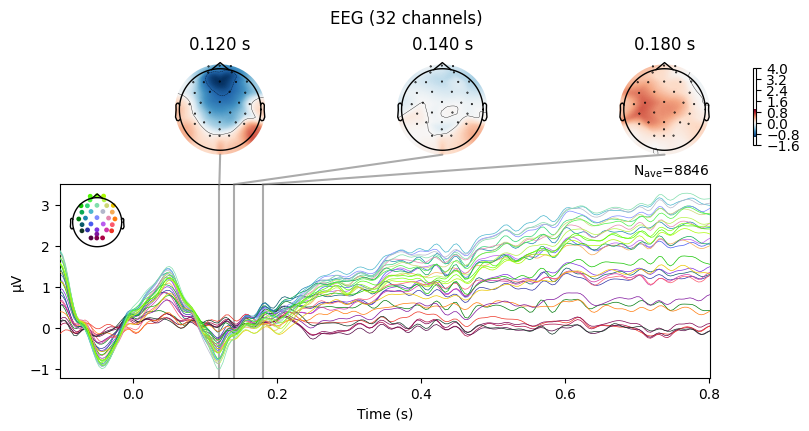

evo_m_std


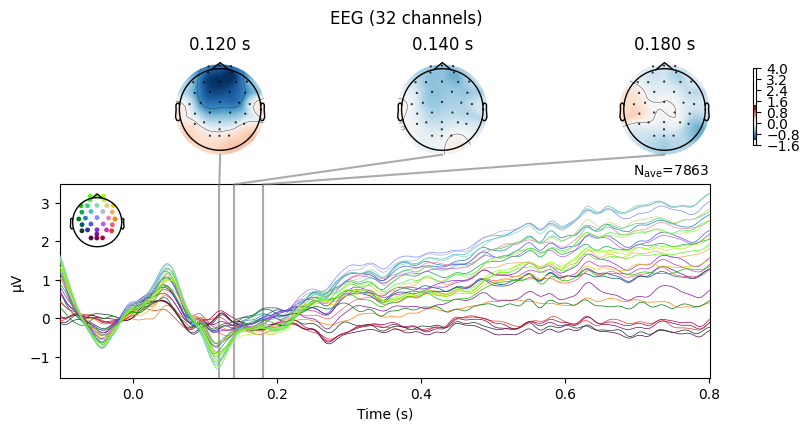

evo_j_dev


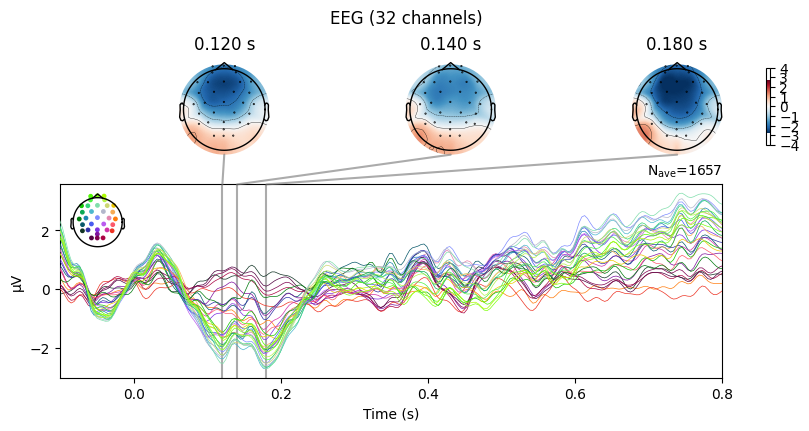

evo_m_dev


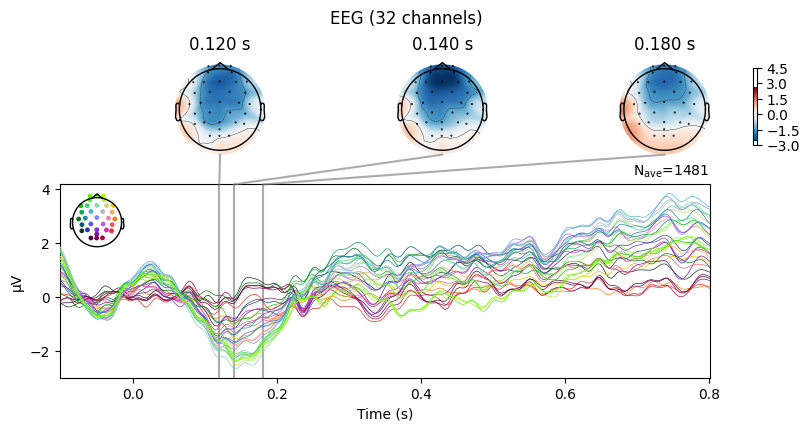

evo_j_diff


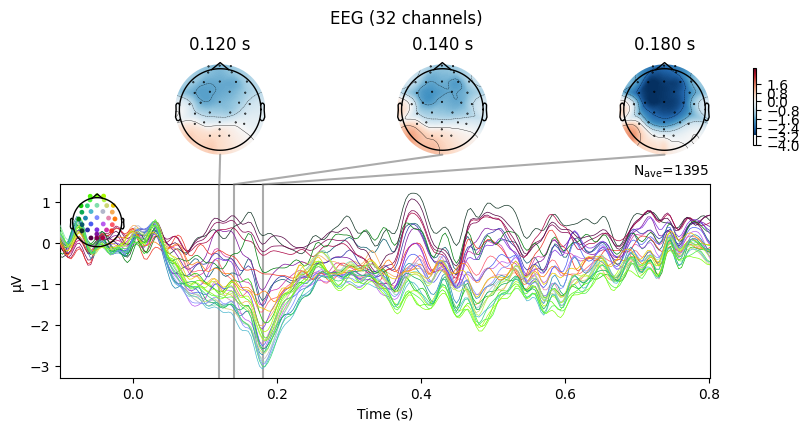

evo_m_diff


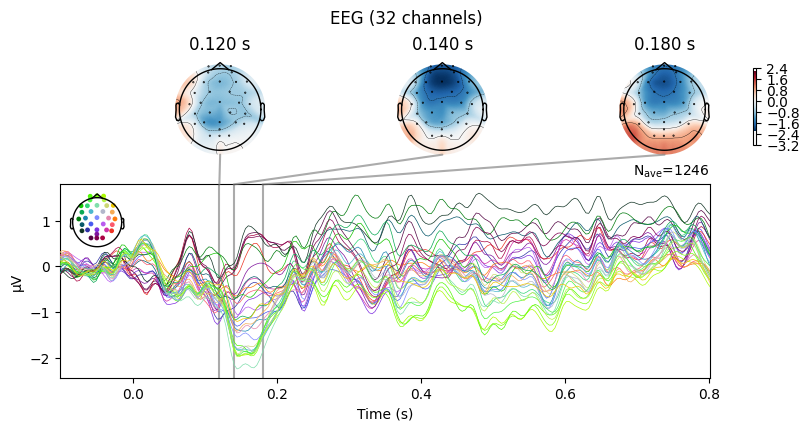

evo_jm_diff


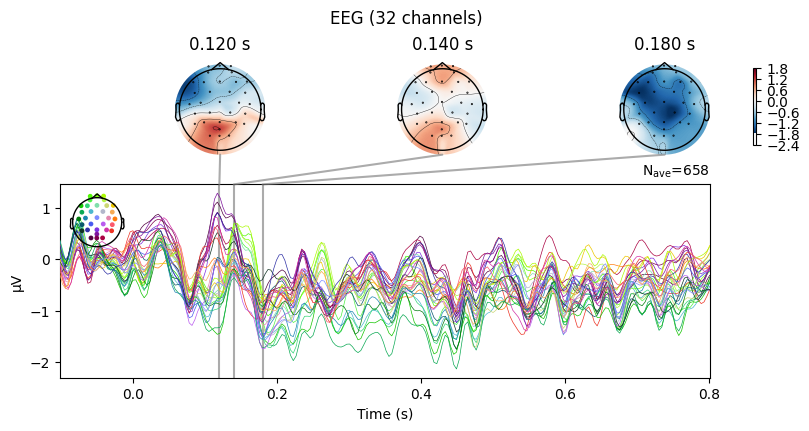

In [31]:
print('evo_j_std')
evo_j_std.plot_joint(times=[0.12, 0.14, 0.18])
print('evo_m_std')
evo_m_std.plot_joint(times=[0.12, 0.14, 0.18])

print('evo_j_dev')
evo_j_dev.plot_joint(times=[0.12, 0.14, 0.18])
print('evo_m_dev')
evo_m_dev.plot_joint(times=[0.12, 0.14, 0.18])

print('evo_j_diff')
evo_j_diff.plot_joint(times=[0.12, 0.14, 0.18])
print('evo_m_diff')
evo_m_diff.plot_joint(times=[0.12, 0.14, 0.18])

print('evo_jm_diff')
evo_jm_diff.plot_joint(times=[0.12, 0.14, 0.18])

print ('')
# change the 0.235

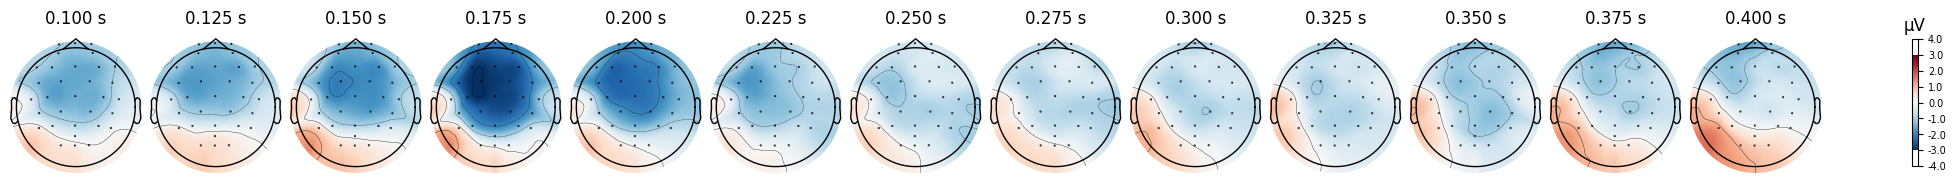

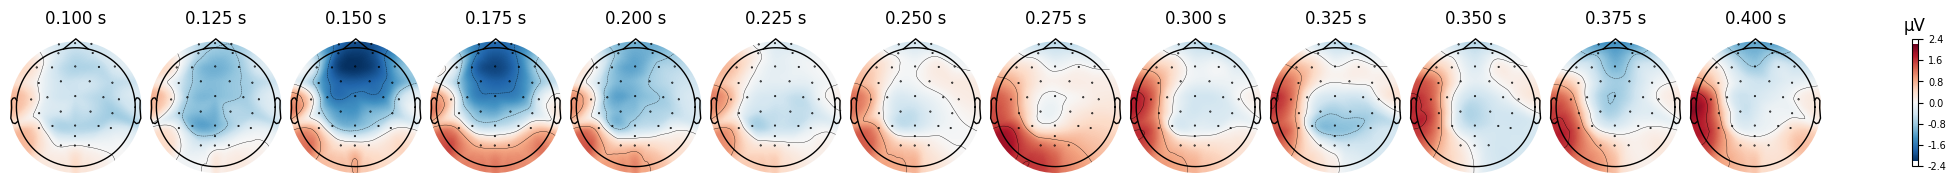

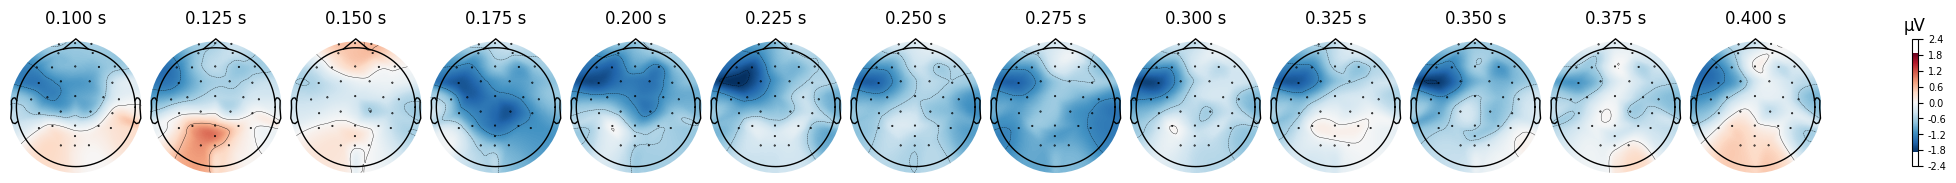

In [34]:
time_points = np.arange(0.1, 0.401, 0.025)  # Time in seconds

for evo in [evo_j_diff, evo_m_diff, evo_jm_diff]:
    evo.plot_topomap(
        times=time_points
    )

print ('')